## Introduction

This notebook is an exploration of translating the text found in images into geolocations

We begin by importing our dependancies and loading the labels

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import json
import seaborn as sns
from geopy import distance
import folium
from geopy.geocoders import Nominatim, Photon, Pelias

nominatim = Nominatim(user_agent="Imperial College London", )
photon = Photon(user_agent="Imperial College London",)
pelias = Pelias(api_key="ge-f3815bf1ea32a3de", domain="https://api.geocode.earth/v1/search")


im2gps = pd.read_json("~/notebooks/im2gps_small.jsonl", lines=True)
im2gps = im2gps.set_index('key')
im2gps3k = pd.read_json("~/notebooks/im2gps3ktest.jsonl", lines=True)
im2gps3k = im2gps3k.set_index('key')
yfcc4k = pd.read_json("~/notebooks/yfcc4k.jsonl", lines=True)
yfcc4k = yfcc4k.set_index('key')

im2gps.drop(columns=['full'], inplace=True)
im2gps3k.drop(columns=['full'], inplace=True)
yfcc4k.drop(columns=['full'], inplace=True)


In [41]:
yfcc4k_locations = pd.read_json("~/notebooks/yfcc4k_locations.jsonl", lines=True)
yfcc4k_locations = yfcc4k_locations.set_index('key')


im2gps3k_locations = pd.read_json("~/notebooks/im2gps3k_locations.jsonl", lines=True)
im2gps3k_locations = im2gps3k_locations.set_index('key')


In [3]:
# sns.displot(df['unique_cluster'].value_counts())

## Load OCR data

We load the text generated from the OCR model. 

We extract each line of text ensureing the watermark in the corner of images is excluded

In [4]:

im2gps['num_lines'] = im2gps['lines'].apply(len)
im2gps3k['num_lines'] = im2gps3k['lines'].apply(len)
yfcc4k['num_lines'] = yfcc4k['lines'].apply(len)


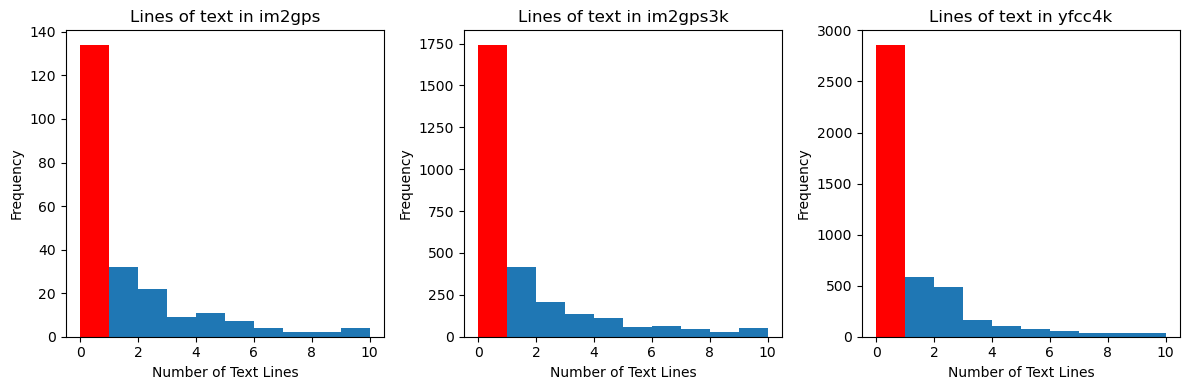

In [29]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Define bins (you can adjust this as needed)
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Loop through dataframes and create histograms on subplots
dataframes = [im2gps, im2gps3k, yfcc4k]
titles = ['Lines of text in im2gps', 'Lines of text in im2gps3k', 'Lines of text in yfcc4k']

for i, (df, title) in enumerate(zip(dataframes, titles)):
    counts, _, patches = axes[i].hist(df['num_lines'], bins=bins)
    patches[0].set_facecolor('red')  # Set color for the first bar (optional)
    axes[i].set_xlabel('Number of Text Lines')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(title)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

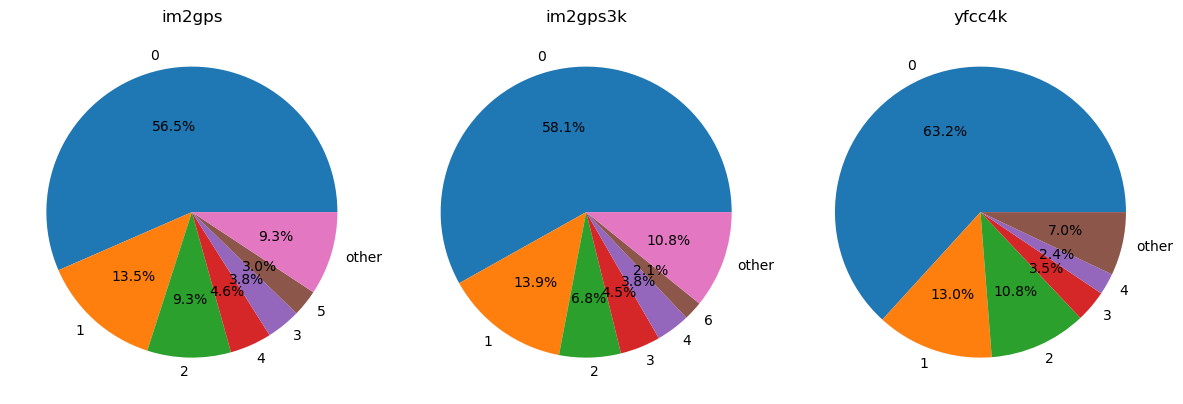

In [30]:
def get_pie_chart_data(df, threshold):
  n_lines_count = df['num_lines'].value_counts().sort_values(ascending=False)
  other_count = 0
  
  pie_chart_slice_labels = []
  pie_chart_slice_values = []
  for label, value in n_lines_count.items():
    proportion = value / df.shape[0]
    if proportion >= threshold:
      pie_chart_slice_labels.append(label)
      pie_chart_slice_values.append(value)
    else:
      other_count += value
  
  if other_count > 0:
    pie_chart_slice_labels.append("other")
    pie_chart_slice_values.append(other_count)

  return pie_chart_slice_labels, pie_chart_slice_values

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

dataframes = [im2gps, im2gps3k, yfcc4k]
titles = ['im2gps', 'im2gps3k', 'yfcc4k']
threshold = 0.02 

for i, (df, title) in enumerate(zip(dataframes, titles)):
  pie_chart_slice_labels, pie_chart_slice_values = get_pie_chart_data(df.copy(), threshold)
  axes[i].pie(pie_chart_slice_values, labels=pie_chart_slice_labels, autopct="%1.1f%%")
  axes[i].set_title(title)

plt.tight_layout()
plt.show()


There are many samples in the dataset that have no text. This can be observed from the empty "lines" column in the dataframe.


Let's analyse the samples with text

In [25]:
im2gps_filtered   = im2gps[im2gps['num_lines'] > 0]
im2gps3k_filtered = im2gps3k[im2gps3k['num_lines'] > 0]
yfcc4k_filtered   = yfcc4k[yfcc4k['num_lines'] > 0]
im2gps3k_filtered.head(n=20)

,lines,lat,lon,num_lines
key,,,,
1001048550_8e4b47d165_1051_78841376@N00.jpg,[ 445],32.325436,-64.764404,1
1008804117_ce4e6fef8a_1349_97522422@N00.jpg,"[ IIIOE XOTIAOCh,, - MOFAOCE!]",46.478536,30.758714,2
1008845063_ace4ef829f_1204_97522422@N00.jpg,"[ XX % A, AO AM MWPA. BCTAHBT, AOTYCTWM HATO...",46.478536,30.758714,9
101220879_0a1be45b79_33_24311489@N00.jpg,[ 6A],42.249915,-87.827110,1
1023756068_20c3ffc329_1039_70323761@N00.jpg,"[ CHARLES FOLLEN MS KA, RC HTES -, A - 30 -...",40.807694,-73.962262,7
103404365_f852148f5b_34_73293249@N00.jpg,"[ FRRFTT, HOTEL FcE, DU]",46.080783,7.399454,3
103442236_09c8d53dbc_37_73293249@N00.jpg,"[ BNAVEZ , a]",51.501821,-0.140655,2
103465274_3e879729e0_33_73293249@N00.jpg,"[ 41, es - E -, Vis, 1n, a *, AAA]",46.080350,7.209918,6
103558896_55f8059bc9_35_73293249@N00.jpg,[ A . -],43.642423,-79.387153,1


In [6]:

print(len(im2gps_filtered))
print(len(im2gps3k_filtered))
print(len(yfcc4k_filtered))

print(im2gps_filtered['num_lines'].sum()+ im2gps3k_filtered['num_lines'].sum()+ yfcc4k_filtered['num_lines'].sum())


103
1255
1662
12196


## Observations 

We see that sizeways imagery has proportanally more text extracted

In [7]:



def display_results(key, df, locations):
    row = df.loc[key]
    map_center=[row['lat'] ,row['lon']]
    mymap = folium.Map(location=map_center, zoom_start=18)
    folium.Marker(
        location=map_center,
        tooltip="groundtruth",
        popup="Ground Truth",
        icon=folium.Icon(color="green"),
        ).add_to(mymap)

    for location in locations:
        if location is None:
            continue
        print(distance.distance((row['lat'] ,row['lon']), (location.latitude,location.longitude)).km)
        folium.Marker(location=[location.latitude,location.longitude],
                    popup=location.address).add_to(mymap)




    tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
        ).add_to(mymap)
    folium.LayerControl().add_to(mymap)  
    return mymap

In [8]:
def get_candidates(lines, providor):
    results = []
    for line in lines:
        items = providor.geocode(line, exactly_one=False)
        if items:
            results.extend(items)
    for i in range(len(lines)-1):
        line = lines[i] + ' ' + lines[i+1]
        items = providor.geocode(line, exactly_one=False)
        if items:
            results.extend(items)
    return results

In [9]:
# get_candidates(im2gps3k_filtered.loc['1054676623_3278c97053_1242_70323761@N00.jpg']['lines'], nominatim) s

In [10]:
#display_results(key, df, locations)

In [11]:
# sSs5DrBBgK2kYuKxy5UHeQ
# key = "sSs5DrBBgK2kYuKxy5UHeQ"

# img = Image.open(f"../mappilary/train_val/{place}/database/images/{key}.jpg")
# print(key)
# print(df.loc[key]['lines'])
# print(df.loc[key]['view_direction'])
# plt.imshow(img)
# plt.show()
# locations = [ geolocator.geocode(text) for text in df.loc[key]['lines'] if text is not None]
# for location in locations:
#     print(location)

# display_results(key, df, locations)

In [12]:

# key = "Mmv38ANrjW68NDpbVJGPnQ"

# img = Image.open(f"../mappilary/train_val/{place}/database/images/{key}.jpg")
# print(key)
# print(df.loc[key]['lines'])
# print(df.loc[key]['view_direction'])
# plt.imshow(img)
# plt.show()
# locations = [ geolocator.geocode(text) for text in df.loc[key]['lines'] if text is not None]
# for location in locations:
#     print(location)

# display_results(key, df, locations)

In [13]:
yfcc4k_filtered.iloc[1661]

lines           [ 12A]
lat          54.517582
lon           -1.43929
num_lines            1
Name: 11894574114.jpg, dtype: object

In [14]:
 yfcc4k_filtered["lines"].apply(lambda x: " This photo is no longer available" in x).sum()

168

In [15]:
len(yfcc4k_filtered["lines"])

1662

In [16]:
import geopy.distance

def add_location_counts(df):
  df['num_nominatim_locations'] = df['locations_nominatim'].apply(len)
  df['num_photon_locations'] = df['locations_photon'].apply(len)
  return df

def calculate_closest_distance(df, providor):
  def get_closest_distance(row):
    lat = row['lat']
    lon = row['lon']
    nominatim_locations = row[f"locations_{providor}"]
    distances = []
    for location in nominatim_locations:
      nom_lat = location['lat']
      nom_lon = location['lon']
      distance = geopy.distance.geodesic((lat, lon), (nom_lat, nom_lon)).km
      distances.append(distance)
    return min(distances) if distances else None

  df[f"closest_{providor}_distance"] = df.apply(get_closest_distance, axis=1)
  return df


In [46]:
yfcc4k_locations = add_location_counts(yfcc4k_locations)
yfcc4k_locations = calculate_closest_distance(yfcc4k_locations, "nominatim")
yfcc4k_locations = calculate_closest_distance(yfcc4k_locations, "photon")

im2gps3k_locations = add_location_counts( im2gps3k_locations)
im2gps3k_locations = calculate_closest_distance(im2gps3k_locations, "nominatim")
im2gps3k_locations = calculate_closest_distance(im2gps3k_locations, "photon")


# im2gps_locations = add_location_counts( im2gps_locations)
# im2gps_locations = calculate_closest_distance(im2gps_locations, "nominatim")
# im2gps_locations = calculate_closest_distance(im2gps_locations, "photon")

yfcc4k_locations.head()

,locations_nominatim,locations_photon,lat,lon,num_nominatim_locations,num_photon_locations,closest_nominatim_distance,closest_photon_distance
key,,,,,,,,
10201275523.jpg,"[{'lat': 49.78503118909091, 'lon': 6.066721285...","[{'lat': 20.0212638, 'lon': 42.5971834}, {'lat...",43.649708,-79.365637,1,29,6205.204714,566.907784
7196543710.jpg,"[{'lat': -4.6486614, 'lon': 34.9571053}]","[{'lat': 49.0769935, 'lon': -58.1213484}, {'la...",-34.885742,138.604736,1,60,10954.989822,1085.727435
3222715183.jpg,"[{'lat': 55.58098845, 'lon': -2.08636644594959...","[{'lat': 55.58098845, 'lon': -2.08636644594959...",52.448235,-1.566066,137,523,350.353060,61.566678
2939073272.jpg,"[{'lat': 37.7892059, 'lon': -122.403475}, {'la...","[{'lat': -26.6742526, 'lon': 153.1001015}, {'l...",26.103065,-80.153190,21,187,489.776544,307.462423
7925056016.jpg,"[{'lat': 59.9329834, 'lon': 30.3690913}, {'lat...","[{'lat': 42.6384261, 'lon': 12.674297}, {'lat'...",50.109166,8.678833,24,60,356.677426,157.820518


In [18]:
def analyze_distances(df):

  summary_stats = {}
  # Calculate descriptive statistics
  for col in ['closest_nominatim_distance', 'closest_photon_distance']:
    summary_stats[col] = {
      'mean': df[col].mean(),
      'median': df[col].median()
    }

  # Define distance thresholds
  thresholds = [1, 25, 200, 750, 2500]

  # Calculate percentage of distances within each threshold range
  for col in ['closest_nominatim_distance', 'closest_photon_distance']:
    summary_stats[col].update({
        'pct_less_' + str(threshold) + 'km': (df[col] < threshold).mean() * 100
        for threshold in thresholds
    })

  return summary_stats


df = analyze_distances(yfcc4k_locations.copy())
df

{'closest_nominatim_distance': {'mean': 3451.861140085742,
  'median': 1587.7581598587428,
  'pct_less_1km': 1.7448856799037304,
  'pct_less_25km': 3.850782190132371,
  'pct_less_200km': 12.214199759326114,
  'pct_less_750km': 26.6546329723225,
  'pct_less_2500km': 46.87123947051745},
 'closest_photon_distance': {'mean': 2150.498182083719,
  'median': 752.2094478817472,
  'pct_less_1km': 2.888086642599278,
  'pct_less_25km': 7.8820697954271965,
  'pct_less_200km': 23.405535499398315,
  'pct_less_750km': 45.30685920577617,
  'pct_less_2500km': 67.26835138387484}}

In [19]:
df['closest_nominatim_distance']

{'mean': 3451.861140085742,
 'median': 1587.7581598587428,
 'pct_less_1km': 1.7448856799037304,
 'pct_less_25km': 3.850782190132371,
 'pct_less_200km': 12.214199759326114,
 'pct_less_750km': 26.6546329723225,
 'pct_less_2500km': 46.87123947051745}

In [20]:
  df['closest_photon_distance']

{'mean': 2150.498182083719,
 'median': 752.2094478817472,
 'pct_less_1km': 2.888086642599278,
 'pct_less_25km': 7.8820697954271965,
 'pct_less_200km': 23.405535499398315,
 'pct_less_750km': 45.30685920577617,
 'pct_less_2500km': 67.26835138387484}

![img](https://cdn.discordapp.com/attachments/1237354836853391360/1237354875474673766/image.png?ex=663b5807&is=663a0687&hm=04fa5802a52939247d52548ebf7b68b30ed406710d99668a139b4ebe10391a6c&)
![img](https://cdn.discordapp.com/attachments/1227386818354479144/1237352850472828949/image.png?ex=663b5624&is=663a04a4&hm=1f3dc463382d2376d0f673b4c6b739953e23da6c912ecf7a5a10577caeba340f&)



In [42]:
im2gps3k_filtered_left = im2gps3k_filtered.loc[~im2gps3k_filtered.index.isin(im2gps3k_locations.index)]


In [43]:
print("left", len(im2gps3k_filtered_left), "done" , len(im2gps3k_locations), "total",  len(im2gps3k_filtered), "expected left",len(im2gps3k_filtered)- len(im2gps3k_locations))

left 0 done 1255 total 1255 expected left 0


In [44]:
im2gps3k_filtered.index.isin(im2gps3k_locations.index)

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
 pd.DataFrame(df).transpose()


In [47]:
analyze_distances(im2gps3k_locations.copy())

{'closest_nominatim_distance': {'mean': 2550.810611227858,
  'median': 1105.3156555482526,
  'pct_less_1km': 2.2310756972111556,
  'pct_less_25km': 6.2151394422310755,
  'pct_less_200km': 15.53784860557769,
  'pct_less_750km': 36.01593625498008,
  'pct_less_2500km': 60.95617529880478},
 'closest_photon_distance': {'mean': 1696.4248353327205,
  'median': 574.8874407796709,
  'pct_less_1km': 3.6653386454183265,
  'pct_less_25km': 11.474103585657371,
  'pct_less_200km': 26.693227091633464,
  'pct_less_750km': 50.3585657370518,
  'pct_less_2500km': 72.19123505976096}}

In [24]:
# yfcc4k_locations
yfcc4k_locations[yfcc4k_locations["num_nominatim_locations"] <= 0]

,locations_nominatim,locations_photon,lat,lon,num_nominatim_locations,num_photon_locations,closest_nominatim_distance,closest_photon_distance
key,,,,,,,,
10593624805.jpg,[],"[{'lat': 36.712189, 'lon': 10.1497278}, {'lat'...",48.862173,2.394075,0,44,NaN,257.682888
5982428132.jpg,[],"[{'lat': 40.746644, 'lon': -73.891338}, {'lat'...",36.160854,-86.777658,0,17,NaN,320.318251
8042343438.jpg,[],"[{'lat': 25.0672934, 'lon': -77.3200947847574}...",37.878070,-122.303199,0,40,NaN,3107.786760
4654689459.jpg,[],"[{'lat': -23.4994687, 'lon': -46.2969436}, {'l...",-35.324229,-72.415351,0,15,NaN,424.764907
4649365193.jpg,[],"[{'lat': 37.339619299999995, 'lon': 126.755228...",47.274400,12.770883,0,7,NaN,333.289043
...,...,...,...,...,...,...,...,...
5448317091.jpg,[],"[{'lat': 23.2091891, 'lon': 57.6599181}, {'lat...",12.559553,-16.696901,0,13,NaN,1601.748378
3625819232.jpg,[],[],13.054437,80.284609,0,0,NaN,NaN
872177729.jpg,[],"[{'lat': 45.8291411, 'lon': 1.2587269}]",-27.228836,-52.030048,0,1,NaN,9715.237526


In [60]:
yfcc4k_locations[yfcc4k_locations["num_photon_locations"] <= 0]

,locations_nominatim,locations_photon,lat,lon,num_nominatim_locations,num_photon_locations,closest_nominatim_distance,closest_photon_distance
key,,,,,,,,
6093950239.jpg,[],[],41.158826,-8.630822,0,0,NaN,NaN
3844614093.jpg,[],[],42.762137,-7.235870,0,0,NaN,NaN
2632108654.jpg,[],[],48.299839,4.080390,0,0,NaN,NaN
8603260545.jpg,"[{'lat': 43.0083269, 'lon': -97.1067167}, {'la...",[],39.632488,2.457127,3,0,7667.522252,NaN
14010060531.jpg,[],[],33.887455,-118.269303,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...
1557879041.jpg,[],[],50.258071,8.247470,0,0,NaN,NaN
6252419899.jpg,"[{'lat': -25.1076701, 'lon': -64.3494964}, {'l...",[],64.144189,-21.927788,5,0,9236.629692,NaN
3625819232.jpg,[],[],13.054437,80.284609,0,0,NaN,NaN
